In [1]:
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from engine.optimizer import build_optimizer,build_lr_scheduler

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
from structures.image_list import ImageList
from engine.detection_checkpointer import DetectionCheckpointer
from data.utils import build_augmentation


In [2]:
cfg = get_cfg()
cfg.merge_from_file('./config_files/voc.yaml')
cfg.MODEL.SAVE_IDX = 22
cfg.MODEL.RPN.USE_MDN=False
cfg.MODEL.ROI_HEADS.USE_MLN= True
cfg.MODEL.RPN.AUTO_LABEL = True
cfg.MODEL.RPN.USE_CLIP = True
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'mul'
cfg.log = False

NUM_CLASSES = 20
NUM_CLASSES += 1
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME

In [3]:
model = GeneralizedRCNN(cfg,'cuda:0').to('cuda:0')
state_dict = torch.load('./ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location='cuda:0')
model.load_state_dict(state_dict)
model.proposal_generator.MODEL.to('cuda:0')

/home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:45: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)
/home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)


auto labeling based on RPN


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [4]:
DIR_NAME = '/data/jeongeun/OWOD_datasets/VOC2007'
split = 'train'
data = load_voc_instances(DIR_NAME,split,VOC_CLASS_NAMES,phase='t1',COCO_CLASS=False)
mapper = DatasetMapper(is_train=True, augmentations=build_augmentation(cfg,True))
data_loader = build_detection_train_loader(data,mapper=mapper,total_batch_size=1)
VOC_CLASS_NAMES_NEW = (*VOC_CLASS_NAMES, 'unknown')
loader = iter(data_loader)
it = 0

210


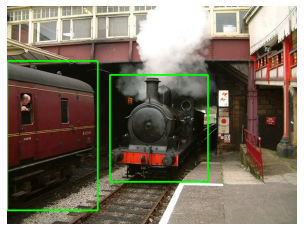

In [47]:
print(it)
batched_inputs = next(loader)
images = model.preprocess_image(batched_inputs)
features = model.backbone(images.tensor)
gt_instances = [x['instances'].to(model.device) for x in batched_inputs]
proposals, proposal_losses,gt_instances = model.proposal_generator(images, features, gt_instances,1.0)

image = batched_inputs[0]['image']
inputs = {"image": batched_inputs[0]['image'], 
            "height": batched_inputs[0]['height'], "width": batched_inputs[0]['width']}
# proposals = model._postprocess(gt_instances,[inputs],images.image_sizes)
height = inputs.get("height", images.image_sizes[0][0])
width = inputs.get("width", images.image_sizes[0][1])


new_size = (height, width)
output_width_tmp = width
output_height_tmp = height
scale_x, scale_y = (
        output_width_tmp / gt_instances[0].image_size[1],
        output_height_tmp / gt_instances[0].image_size[0],
    )
output_boxes = gt_instances[0].gt_boxes
output_boxes.scale(scale_x, scale_y)
output_boxes.clip(gt_instances[0].image_size)

file_name = batched_inputs[0]['file_name']
demo_image = cv2.imread(file_name)
boxes = output_boxes.tensor
labels = gt_instances[0].gt_classes
for label,bbox in zip(labels,boxes):
    if label == 20:
        color = (255,255,0)
    else:
        color = (0,255,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                            (int(bbox[2]),int(bbox[3])), color, 2)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.savefig('./dummy/proposals/{}'.format(it))
plt.show()
it+=5